# Вариант получения части предсказаний на основе _applications_history.csv_

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import category_encoders as ce
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import  StratifiedKFold

from sklearn.metrics import confusion_matrix
pd.options.display.max_columns=202
pd.options.display.max_rows=202

from typing import List, Optional
import re

import warnings
warnings.filterwarnings("ignore")
np.random.seed(1)

In [2]:
df_train = pd.read_csv('./geekbrains-competitive-data-analysis/train.csv')
df_test  = pd.read_csv('./geekbrains-competitive-data-analysis/test.csv')
df_applications_history  = pd.read_csv('./geekbrains-competitive-data-analysis/applications_history.csv')

In [3]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    
    
def fill_nan_by_median_one(train_cleaned):
    train_features = [i for i in train_cleaned.columns]
    for i in train_features:        
        train_cleaned[i] = train_cleaned[i].fillna(train_cleaned[i].median())
    return train_cleaned

def fill_nan_by_median(train_cleaned, valid_cleaned, test_cleaned):
    train_features = [i for i in train_cleaned.columns]
    for i in train_features:        
        train_cleaned[i] = train_cleaned[i].fillna(train_cleaned[i].median())
        test_cleaned[i]  = test_cleaned[i].fillna(test_cleaned[i].median())        
        valid_cleaned[i] = valid_cleaned[i].fillna(valid_cleaned[i].median())      
    return train_cleaned, valid_cleaned, test_cleaned


def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}" for feature, stat in stats]
    stats = stats.reset_index()

    return stats





def data_preparade(df_train, df_test, df_applications_history):

    to_del =['PREV_APPLICATION_NUMBER']
    
    df_applications_history = df_applications_history.drop(to_del, axis=1)
    
    
    categorical_feats = [f for f in df_applications_history.columns if df_applications_history[f].dtype == 'object']
    df_applications_history = pd.get_dummies(df_applications_history, columns=categorical_feats)
    
    df_applications_history = df_applications_history.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))    
#---------------------------------------------------------------------------------------------------------------------------
    
    df_applications_history = fill_nan_by_median_one(df_applications_history)
    
    
    
    apps=df_applications_history

    aggs ={}
    for i in df_applications_history.columns:
        aggs[i]=[np.sum,  np.max]

    #mask = apps["CREDIT_ACTIVE"] == 1
    df_applications_history = create_numerical_aggs(
                                    #apps[mask], 
                                    apps,
                                    groupby_id="APPLICATION_NUMBER", 
                                    aggs=aggs, prefix="", 
                                    suffix=""
                                    )
#---------------------------------------------------------------------------------------------------------------------------        

    df_applications_history = fill_nan_by_median_one(df_applications_history)    
    print('Original shapes:', df_train.shape, df_test.shape)
    
   
    
    
    applications_numbers = list(df_applications_history['APPLICATION_NUMBER'].values)
    train_numbers = list(df_train['APPLICATION_NUMBER'].values)
    test_numbers  = list(df_test['APPLICATION_NUMBER'].values)      
    train_in_profiles = list(set(train_numbers) & set(applications_numbers))
    test_in_profiles = list(set(test_numbers) & set(applications_numbers))       
    df_train = df_train[(df_train['APPLICATION_NUMBER'].isin(train_in_profiles))]
    df_test = df_test[(df_test['APPLICATION_NUMBER'].isin(test_in_profiles))]    
    
    
    
    
    target = df_train['TARGET']
    df_train = df_train.drop(['TARGET'], axis=1)
    
    
   
    dic = {'Cash':1, 'Credit Card':2}
    df_train['NAME_CONTRACT_TYPE'] = df_train['NAME_CONTRACT_TYPE'].map(dic)
    df_test['NAME_CONTRACT_TYPE'] = df_test['NAME_CONTRACT_TYPE'].map(dic)

    
  
    
    
    df_train = pd.merge(df_train, df_applications_history, how='left', on=['APPLICATION_NUMBER'])
    df_test = pd.merge(df_test, df_applications_history, how='left', on=['APPLICATION_NUMBER'])    
    
    

    print('Final shapes:', df_train.shape, df_test.shape)    
    
    cat_list = []
      
    return df_train, target, df_test, cat_list


In [4]:
def lgb_run(X_train, X_valid, X_test, y_train, y_valid, cat_list):
    import lightgbm as lgb    
       
    train_cleaned, valid_cleaned, test_cleaned = X_train, X_valid, X_test    
   
    params = {
        "boosting_type": "goss",
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.003,
        "n_jobs": 7,
        "seed": 15,
        "max_depth": 5,
        "verbose": -1,
    }
    

    dtrain = lgb.Dataset(
        data=train_cleaned, label=y_train
    )
    dvalid = lgb.Dataset(
        data=valid_cleaned,  label=y_valid
    )

    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=7500,
        valid_sets=[dtrain, dvalid],
        categorical_feature="auto",
        early_stopping_rounds=250,
        #verbose_eval=100,
        verbose_eval=False,
    )

    ypred_train = model.predict(train_cleaned)
    ypred_valid = model.predict(valid_cleaned)
    ypred_test = model.predict(test_cleaned)

    print('roc_auc_score:', roc_auc_score(y_valid, ypred_valid))
    print('lgb pass ==========================================')
    print()
    return ypred_train, ypred_valid, ypred_test

In [5]:
def xgb_run(X_train, X_valid, X_test, y_train, y_valid, cat_list):

    import xgboost as xgb    
    
    train_cleaned, valid_cleaned, test_cleaned = X_train, X_valid, X_test    

    params = {
        "booster": "gbtree",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": 0.0145,
    #    "reg_lambda": 10,
        "max_depth": 5,
    #    "gamma": 10,
        "nthread": 7,
        "seed": 15,

    }
    

    dtrain = xgb.DMatrix(
        data=train_cleaned, label=y_train
    )
    dvalid = xgb.DMatrix(
        data=valid_cleaned,  label=y_valid
    )

    dtest = xgb.DMatrix(
        data=test_cleaned
    )        


    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1500,
        early_stopping_rounds=150,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        #verbose_eval=100,
        verbose_eval=False,
        maximize=True
    )    

    ypred_train = model.predict(dtrain)
    ypred_valid = model.predict(dvalid)        
    ypred_test = model.predict(dtest)

    print('roc_auc_score:', roc_auc_score(y_valid, ypred_valid))
    print('xgb pass ==========================================')
    print()
    
    return ypred_train, ypred_valid, ypred_test

In [6]:
def cb_run(X_train, X_valid, X_test, y_train, y_valid, cat_list):

    import catboost as cb
    from catboost import Pool

    train_cleaned, valid_cleaned, test_cleaned = X_train, X_valid, X_test    
       

    cb_params = {
        "n_estimators": 2000,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "verbose": 0,
        "max_depth": 7,
        "l2_leaf_reg": 100,
        "early_stopping_rounds": 150,
        "thread_count": 7,
        "random_seed": 15
    }

    cv_dataset = Pool(data=train_cleaned,
                      label=y_train,
                      )

    model = cb.CatBoostClassifier(**cb_params)
    model.fit(
        X=train_cleaned,
        y=y_train,
        eval_set=[(train_cleaned, y_train), (valid_cleaned, y_valid)],
        plot=False
    )    
    ypred_train = model.predict_proba(train_cleaned)
    ypred_valid = model.predict_proba(valid_cleaned)
    ypred_test = model.predict_proba(test_cleaned)


    print('roc_auc_score:', roc_auc_score(y_valid, ypred_valid[:,1]))
    print('cb  pass ==========================================')
    print()
    
    return ypred_train, ypred_valid, ypred_test

In [7]:
train, target_train, X_test, cat_list = data_preparade(df_train, df_test, df_applications_history)
X_test_id = X_test['APPLICATION_NUMBER']
train = train.drop(['APPLICATION_NUMBER'],axis=1)
X_test = X_test.drop(['APPLICATION_NUMBER'],axis=1)

temp=train.select_dtypes(include=['float64'])
train[temp.columns] = train[temp.columns].astype('float32')
X_test[temp.columns] = X_test[temp.columns].astype('float32')

Original shapes: (110093, 3) (165141, 2)
Final shapes: (104656, 174) (157084, 174)


In [8]:
selected_features=train.columns

kf = StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

y_true_val_parts  =[]
y_parts_pred      =[]
y_test_preds      =[] 

scors_list=[]
cut_list  =[]

for train_index, valid_index in kf.split(train, target_train):

    
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = target_train.iloc[train_index], target_train.iloc[valid_index]
    
    X_test_copy = X_test.copy()
    
    

    X_train, X_valid, X_test_copy = fill_nan_by_median(X_train, X_valid, X_test_copy )


    X_train = X_train[selected_features]
    X_valid = X_valid[selected_features]
    X_test_copy  = X_test_copy[selected_features]    
    
    
    
    
    
    train_lgb_predictions, valid_lgb_predictions, test_lgb_predictions = lgb_run(X_train, X_valid, X_test_copy, y_train, y_valid, cat_list)
    train_xgb_predictions, valid_xgb_predictions, test_xgb_predictions = xgb_run(X_train, X_valid, X_test_copy, y_train, y_valid, cat_list)
    train_cb_predictions, valid_cb_predictions, test_cb_predictions = cb_run(X_train, X_valid, X_test_copy, y_train, y_valid, cat_list)
 
    
    
    ypred_valid=(valid_cb_predictions[:,1]*valid_xgb_predictions*valid_lgb_predictions)**(1/3)
    ypred_test =(test_cb_predictions[:,1]*test_xgb_predictions*test_lgb_predictions)**(1/3)
    
    ypred_valid_summ=(valid_cb_predictions[:,1]+valid_xgb_predictions+valid_lgb_predictions)/3
    ypred_test_summ =(test_cb_predictions[:,1]+test_xgb_predictions+test_lgb_predictions)/3    
    
    
    ypred_valid_lgb_xgb_mul=(valid_xgb_predictions*valid_lgb_predictions)**(1/2)
    ypred_test_lgb_xgb_mul =(test_xgb_predictions*test_lgb_predictions)**(1/2)
    
    ypred_valid_lgb_cb_mul=(valid_cb_predictions[:,1]*valid_lgb_predictions)**(1/2)
    ypred_test_lgb_cb_mul =(test_cb_predictions[:,1]*test_lgb_predictions)**(1/2)    
    
    ypred_valid_xgb_cb_mul=(valid_cb_predictions[:,1]*valid_xgb_predictions)**(1/2)
    ypred_test_xgb_cb_mul =(test_cb_predictions[:,1]*test_xgb_predictions)**(1/2)        
    
    ypred_valid_lgb_xgb_summ=(valid_xgb_predictions+valid_lgb_predictions)/2
    ypred_test_lgb_xgb_summ =(test_xgb_predictions+test_lgb_predictions)/2

    ypred_valid_lgb_cb_summ=(valid_cb_predictions[:,1]+valid_lgb_predictions)/2
    ypred_test_lgb_cb_summ =(test_cb_predictions[:,1]+test_lgb_predictions)/2
    
    ypred_valid_xgb_cb_summ=(valid_cb_predictions[:,1]+valid_xgb_predictions)/2
    ypred_test_xgb_cb_summ =(test_cb_predictions[:,1]+test_xgb_predictions)/2
        
    
    
    
    scor           = roc_auc_score(y_valid, ypred_valid)
    scor_summ      = roc_auc_score(y_valid, ypred_valid_summ)    
    valid_lgb_scor = roc_auc_score(y_valid, valid_lgb_predictions)
    valid_xgb_scor = roc_auc_score(y_valid, valid_xgb_predictions)    
    valid_cb__scor = roc_auc_score(y_valid, valid_cb_predictions[:,1])    
    
    valid_lgb_xgb_mul__scor = roc_auc_score(y_valid, ypred_valid_lgb_xgb_mul)        
    valid_lgb_cb_mul__scor  = roc_auc_score(y_valid, ypred_valid_lgb_cb_mul)            
    valid_xgb_cb_mul__scor  = roc_auc_score(y_valid, ypred_valid_xgb_cb_mul)        
    
    valid_lgb_xgb_summ__scor = roc_auc_score(y_valid, ypred_valid_lgb_xgb_summ)        
    valid_lgb_cb_summ__scor  = roc_auc_score(y_valid, ypred_valid_lgb_cb_summ)            
    valid_xgb_cb_summ__scor  = roc_auc_score(y_valid, ypred_valid_xgb_cb_summ)        
        
    
    
    
    scors_list = [scor,scor_summ, valid_lgb_scor, valid_xgb_scor, valid_cb__scor,
                 valid_lgb_xgb_mul__scor, valid_lgb_cb_mul__scor, valid_xgb_cb_mul__scor,
                 valid_lgb_xgb_summ__scor, valid_lgb_cb_summ__scor, valid_xgb_cb_summ__scor]
    
    
    TEST_preds_list = [ypred_test, ypred_test_summ, test_lgb_predictions, test_xgb_predictions, test_cb_predictions[:,1],
                      ypred_test_lgb_xgb_mul, ypred_test_lgb_cb_mul, ypred_test_xgb_cb_mul,
                      ypred_test_lgb_xgb_summ, ypred_test_lgb_cb_summ, ypred_test_xgb_cb_summ]
    
    
    VAL__preds_list = [ypred_valid, ypred_valid_summ, valid_lgb_predictions, valid_xgb_predictions, valid_cb_predictions[:,1],
                      ypred_valid_lgb_xgb_mul, ypred_valid_lgb_cb_mul, ypred_valid_xgb_cb_mul,
                      ypred_valid_lgb_xgb_summ, ypred_valid_lgb_cb_summ,ypred_valid_xgb_cb_summ ]    

    
    name_list = ['mul','summ','lgb', 'xgb', 'cb',
                 'lgb_xgb_mul', 'lgb_cb_mul', 'xgb_cb_mul',
                 'lgb_xgb_summ', 'lgb_cb_summ', 'xgb_cb_summ'
                ]       
    
    
    
    to_choice=np.array(scors_list)
    choice = to_choice.argmax()

    print(scors_list[choice],  name_list[choice])    
    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, ypred_valid, pos_label=1)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_threshold

    scors_list.append(scor)
    cut_list.append(optimal_threshold)   
    
    
    y_true_val_parts.append(y_valid.values)
    y_parts_pred.append(VAL__preds_list[choice])
    if scors_list[choice] > 0.502:
        y_test_preds.append(TEST_preds_list[choice])

    print('==========================================================================')
    print()
    print()


roc_auc_score: 0.5199155873694639
lgb pass ==========================================

roc_auc_score: 0.5043869413591893
xgb pass ==========================================

roc_auc_score: 0.5098077624587206
cb  pass ==========================================

0.5199155873694639 lgb


roc_auc_score: 0.5160715774388213
lgb pass ==========================================

roc_auc_score: 0.4984231587134305
xgb pass ==========================================

roc_auc_score: 0.5095124284825556
cb  pass ==========================================

0.5160715774388213 lgb


roc_auc_score: 0.516959954082315
lgb pass ==========================================

roc_auc_score: 0.5161123295556937
xgb pass ==========================================

roc_auc_score: 0.522237075087766
cb  pass ==========================================

0.522237075087766 cb


roc_auc_score: 0.5189543169353125
lgb pass ==========================================

roc_auc_score: 0.5039821950998424
xgb pass ================

In [9]:
y_end =y_test_preds[0]
y     =y_true_val_parts[0].reshape(-1,1)
y_pred=y_parts_pred[0].reshape(-1,1)


for i in range(1,len(y_true_val_parts)):
    y_true_val_parts[i]=y_true_val_parts[i].reshape(-1,1)
    y_parts_pred[i]=y_parts_pred[i].reshape(-1,1)  

    y=np.vstack((y,y_true_val_parts[i]))
    y_pred=np.vstack((y_pred,y_parts_pred[i]))  
    

for i in range(1,len(y_test_preds)):

    y_end         = y_end*y_test_preds[i]
y_end      = y_end**(1/len(y_test_preds))

result = pd.DataFrame(X_test_id)
result['TARGET']=y_end


In [10]:
y_end.shape, y_pred.shape, y.shape

((157084,), (104656, 1), (104656, 1))

0.08073359978660843


0.5167914021481161

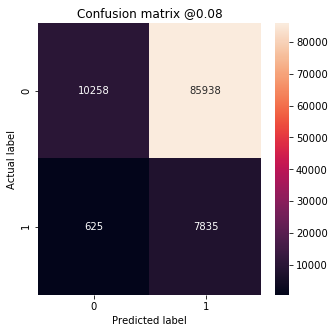

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred,  drop_intermediate=False)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

plot_cm(y, y_pred, p=optimal_threshold)
roc_auc_score(y, y_pred)

In [12]:
base = 0.08144169606994153
k = base/optimal_threshold

In [13]:
correct_result = result.copy()
correct_result['TARGET'] = result['TARGET'].values*k
cor_y_pred = y_pred*k

fpr, tpr, thresholds = metrics.roc_curve(y, cor_y_pred,  drop_intermediate=False)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)


correct_result.to_csv('./result/result_applic_part.csv', index=False)

0.08144169606994152
